## Assumptions
* space_dependent - these are cast to functions, not commutative

* momentum_symbols - will be specified (default to kx, ky, kz probably) and not commutative

* constant - commutative, everything else

* coordinates are always create as symbol with commutative=False

* lattice constant is always a

In [1]:
import sympy
from sympy.interactive import printing
printing.init_printing(use_latex='mathjax')

from discretizer import coord, a
from discretizer import substitute_functions, derivate

## Defining input expression

In [2]:
A, B, C, D = sympy.symbols('A B C D', commutative=False)
space_dependent = ['A', 'B']

In [3]:
expr = B*C*A + D; expr

B⋅C⋅A + D

## Substituting functions

In [4]:
expr = substitute_functions(expr, space_dependent); expr

D + B(x, y, z)⋅C⋅A(x, y, z)

## Calculation derivation

In [5]:
expr

D + B(x, y, z)⋅C⋅A(x, y, z)

In [6]:
derivate(expr, (1, 0, 0))

  - -0.5⋅ⅈ⋅B(-a + x, y, z)⋅C⋅A(-a + x, y, z)    0.5⋅ⅈ⋅B(a + x, y, z)⋅C⋅A(a + x
- ─────────────────────────────────────────── + ──────────────────────────────
                       a                                          a           

, y, z)
───────
       

# Walking sympy tree

In [12]:
from sympy.printing.dot import dotprint
from graphviz import Source
graph = lambda x: Source(dotprint(x))

In [67]:
kx, ky, kz = sympy.symbols('k_x k_y k_z', commutative=False)
Psi = sympy.Symbol('Psi', commutative=False) #sympy.Function('Psi')(*coord)


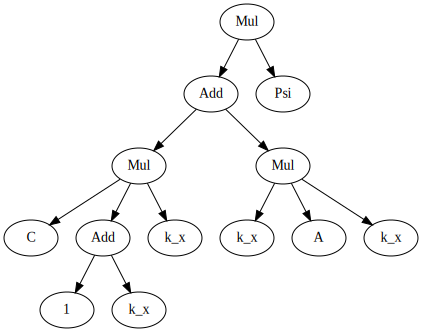

In [70]:
expr = kx*A*kx + C * (kx+1) * kx
expr = expr * Psi
graph(expr)

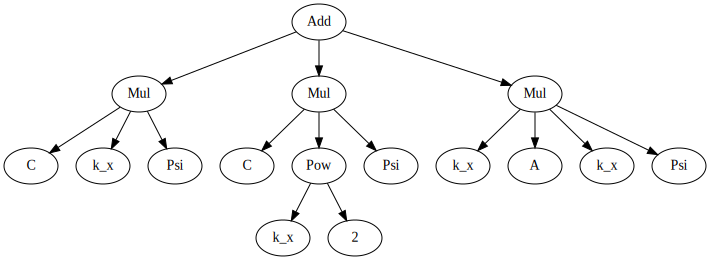

In [71]:
graph(sympy.expand(expr))

In [74]:
expr = sympy.expand(expr)
print(expr.func == sympy.Add)
summands = expr.args

True


In [106]:
summands

⎛            2             ⎞
⎝C⋅kₓ⋅Ψ, C⋅kₓ ⋅Ψ, kₓ⋅A⋅kₓ⋅Ψ⎠

In [108]:
subexpr = summands[0]

In [110]:
subexpr.func == sympy.Mul

True

In [118]:
momentum_operators = [kx, ky, kz]

for subexpr in expr.args:
    print("Testing:", subexpr)
    for arg in subexpr.args[::-1]:
        print('\t', arg, arg in momentum_operators)
        
    print()

Testing: C*k_x*Psi
	 Psi False
	 k_x True
	 C False

Testing: C*k_x**2*Psi
	 Psi False
	 k_x**2 False
	 C False

Testing: k_x*A*k_x*Psi
	 Psi False
	 k_x True
	 A False
	 k_x True

